# T4 - People and data

Modeling without data is like riding a bicycle while blindfolded – rarely dull, but often you don't get to where you want to go. This tutorial shows how to use data with Covasim, and gives a brief introduction to people, populations, and contact layers.

<div class="alert alert-info">
    
Click [here](https://mybinder.org/v2/gh/institutefordiseasemodeling/covasim/HEAD?urlpath=lab%2Ftree%2Fdocs%2Ftutorials%2Ftut_people.ipynb) to open an interactive version of this notebook.
    
</div>

## Data requirements

Covasim is intentionally designed to be flexible with data requirements, acknowledging that some settings have large amounts of data, while others have very little. There are, however, some minimum data requirements if a real-world context is being modeled (as opposed to a theoretical exploration). These are:

- **Population size:** To interpret results correctly, you need to know what the correct denominator is. Typically this is the city or country you're modeling, but sometimes it's not as simple as it may seem, especially early in an epidemic when cases tend to be concentrated near the source of the outbreak.
- **Deaths per day:** Often considered to be the most reliable source of data, since deaths tend to be under-reported less than infections; however, significant under-reporting can still occur, so always treat reported deaths as the *lower* limit of the true value.
- **Diagnosed cases per day:** Diagnosed cases are the most responsive measure of the epidemic conditions; however, they are dependent on both the number of infections and the testing rate. In settings with low or highly variable rates of testing, they may not be especially reliable.

In addition to these essential data requirements, several other pieces of data are useful to have. These are:
- **Seroprevalence:** Although seroprevalence rates wane over time, they are generally a more reliable indicator of total infections than diagnosed cases.
- **Tests per day:** The number of tests can be used directly in the `test_num` intervention (see Tutorial 5), and is very useful for interpreting diagnoses data.
- **Vaccinations per day:** In locations with high vaccination rates, understanding when the vaccines were rolled out (and with which vaccines) is important for estimating current immunity levels.
- **Policy interventions:** While changes in transmission can often be seen directly in the data on cases and deaths, at minimum it is a useful sanity check to see if these changes line up with changes in policy such as mobility restrictions or mask mandates.

## Demographic data

Covasim includes pre-downloaded data on country (and US state) age distributions and household size distributions. As we saw in Tutorial 1, you can load these data simply by using the `location` parameter. You can show a list of all available locations with `cv.data.show_locations()`. The data themselves are simply a set of dictionaries, and these can be modified directly; for example, to add a custom age distribution for Johannesburg would look like this:

```python
# Note data format and key names!
joburg_pop = {
   '0-9':  286620,
  '10-19': 277020,
  '20-29': 212889,
  '30-39': 161329,
  '40-49': 104399,
  '50-59': 51716,
  '60-69': 36524,
  '70-79': 22581,
  '80+':   7086,
}

cv.data.country_age_data.data['Johannesburg'] = joburg_pop
```

You can then use these data via `sim = cv.Sim(location='Johannesburg')`.

## Epidemiological data scrapers

Covasim includes a script to automatically download time series data on diagnoses, deaths, and other epidemiological information from several major sources of COVID-19 data. These include the [Corona Data Scraper](https://coronadatascraper.com), the [European Centre for Disease Prevention and
Control](https://www.ecdc.europa.eu/en/geographical-distribution-2019-ncov-cases), and the [COVID Tracking Project](https://covidtracking.com). These scrapers provide data for a large number of locations (over 4000 at the time of writing), including the US down to the county level and many other countries down to the district level. The data they download is already in the correct format for Covasim.

<div class="alert alert-warning">
    
**Note:** These data sources are frequently updated, and some may no longer work. Please contact us at info@covasim.org if you're having trouble.
    
</div>

## Data input and formats

The correct input data format for Covasim looks like this:

In [ ]:
import pandas as pd
df = pd.read_csv('example_data.csv')
print(df)

The data can be CSV, Excel, or JSON format. There **must** be a column named `date` (not "Date" or "day" or anything else). Otherwise, each column label must start with `new_` (daily) or `cum_` (cumulative) and then be followed by any of: `tests`, `diagnoses`, `deaths`, `severe` (corresponding to hospitalizations), or `critical` (corresponding to ICU admissions). While other columns can be included and will be loaded, they won't be parsed by Covasim. Note that if you enter a `new_` (daily) column, Covasim will automatically calculate a `cum_` (cumulative) column for you.

<div class="alert alert-info">
    
**Note:** Sometimes date information fails to be read properly, especially when loading from Excel files via pandas. If you encounter this problem, see Tutorial 10 for help on fixing this.
    
</div>

This example shows how a simulation can load in the data, and how it automatically plots it. (We'll cover interventions properly in the next tutorial.)

In [ ]:
import covasim as cv
cv.options(jupyter=True, verbose=0)

pars = dict(
    start_day = '2020-02-01',
    end_day   = '2020-04-11',
    beta      = 0.015,
)
sim = cv.Sim(pars=pars, datafile='example_data.csv', interventions=cv.test_num(daily_tests='data'))
sim.run()
sim.plot(['cum_tests', 'cum_diagnoses', 'cum_deaths'])

As you can see, this is not a great fit to data – but we'll come to calibration in Tutorial 7.

## People and contact network layers

### How people work

Agents in Covasim are contained in an object called `People`, which contains all of the agents' properties, as well as methods for changing them from one state to another (e.g., from susceptible to infected).

Agents interact with each other via one or more *contact layers*. You can think of each agent as a node in a mathematical graph, and each connection as an edge. By default, Covasim creates a single random contact network where each agent is connected to 20 other agents, completely at random. However, this is not a very realistic representation of households, workplaces, schools, etc.

For greater realism, Covasim also comes with a "hybrid" population option, which provides a more realism while still being fast to generate. (It's called "hybrid" because it's a combination of the random network and the [SynthPops](http://synthpops.org) network, described in Tutorial 11, which is much more realistic but requires a lot of data and is computationally intensive.) The hybrid option provides four *contact layers*: households `'h'`, schools `'s'`, workplaces `'w'`, and community interactions `'c'`. Each layer is defined by (a) which agents are connected to which other agents, and (b) the weight of each connection (i.e., transmission probability). Specifically:
* Households are small clusters, usually 2-5 people (depending on country), consisting of a wide variety of ages; this setting has high transmission probability
* Schools are split into classrooms, usually about 20 students each, of students aged 6–22; this setting has medium transmission probability
* Workplaces are clusters of about 5-20 people, aged (approximately) 22-65; this setting has medium transmission probability
* Community contacts (representing parks, restaurants, transport, places of worship, etc.) are estimated as 20 random contacts per day; this setting has low transmission probability

### Loading population data

Note that for most countries, you can load default data (age distribution and household size, both from the UN) by using the `location` keyword when creating a sim. For example, to create a realistic (i.e. hybrid) population 10,000 people for Bangladesh and plot the results, you would do:

Initializing sim with 10000 people for 60 days
Loading location-specific data for "United States"


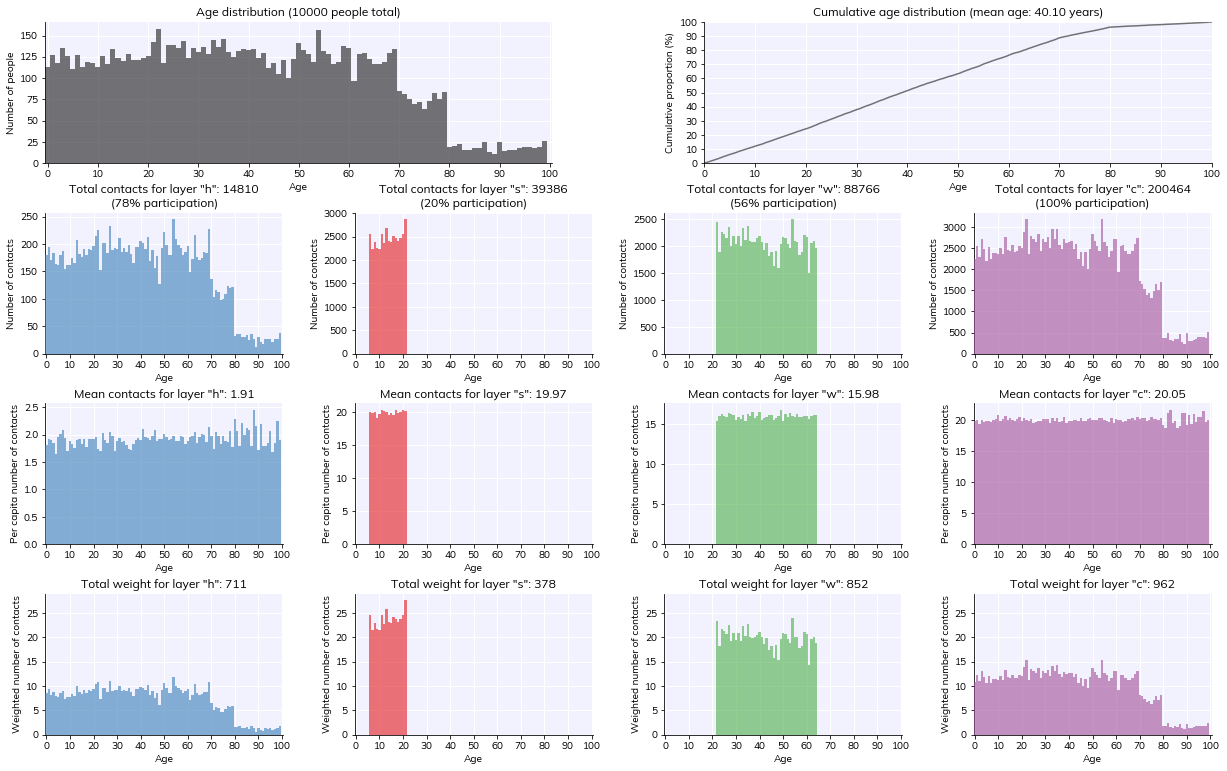

In [9]:
pars = dict(
    pop_size = 10_000, # Alternate way of writing 10000
    pop_type = 'hybrid',
    location = 'United States', # Case insensitive
)

sim = cv.Sim(pars)
sim.initialize() # Create people
fig = sim.people.plot() # Show statistics of the people

In [10]:
sim.people.story(1)


This is the story of 1, a 25 year old male, who did not contract COVID.
1 is connected to 1 people in the household layer
1 is connected to 17 people in the workplace layer
1 is connected to 22 people in the community layer
1 has no contacts in the school layer(s)
1 has 40 contacts in total
Nothing happened to 1 during the simulation.


In [15]:
import os
os.path.abspath(cv.__file__)

'/Users/erinstafford/opt/anaconda3/lib/python3.9/site-packages/covasim/__init__.py'

<div class="alert alert-info">

**Note:** For an explanation of population size, total population, and dynamic rescaling, please see the [FAQ](https://docs.idmod.org/projects/covasim/en/latest/faq.html#what-are-the-relationships-between-population-size-number-of-agents-population-scaling-and-total-population).
    
</div>

### Saving and loading people

Since creating populations can be slow, and since deleting people is a bit mean, sometimes you want to save the population to work with it later. To do this, initialize the people, save them, then load them again. (This example also illustrates how you can use `sc.timer()` to check how long a block of code takes.)

In [ ]:
import sciris as sc # We'll use this to time how long each one takes

pars = dict(n_agents=50e3, pop_type='hybrid')

with sc.timer('creating'):
    sim1 = cv.Sim(pars).init_people()

sim1.people.save('my-people.ppl')

with sc.timer('loading'):
    sim2 = cv.Sim(pars, popfile='my-people.ppl').init_people()

In [ ]:
sim1.people.story(1)

It's about twice as fast to load a population than create one, but whether this will actually matter to you depends on the population size and the length of the simulation.